In [1]:
from __future__ import division
import os.path
import sys
import tqdm # task bar
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import idx2numpy as inp
import scipy.sparse.linalg
import scipy.spatial.distance as dist

# Loads Database

In [2]:
# also vectorises each 28 x 28 pixel image to a 784-element vector
TrImgs_ = np.array([img.flatten() for img in inp.convert_from_file('train-images.idx3-ubyte')])
TrLbls = inp.convert_from_file('train-labels.idx1-ubyte')
TsImgs_ = np.array([img.flatten() for img in inp.convert_from_file('t10k-images.idx3-ubyte')])
TsLbls = inp.convert_from_file('t10k-labels.idx1-ubyte')

## Simple Tools

In [3]:
show = lambda img: plt.imshow(img.reshape(28,28)) # show vectorised alphabet
mm = lambda arr: (np.min(arr),np.max(arr))
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

# Remove subspaces with no information

In [4]:
AllImgs=np.append(TrImgs_,TsImgs_,axis=0)
populated=np.any(np.absolute(AllImgs),axis=0)
# plt.figure('populated subspace');show(populated);
Mask = lambda imgs, mask: np.array([img[mask] for img in imgs])
TrImgs = Mask(TrImgs_,populated)
TsImgs = Mask(TsImgs_,populated)
print('reduced space = {}'.format(np.sum(populated)))

reduced space = 719


In [5]:
# calculate TRAINING IMGS mean for use in rest of program
TrImgsMean = (np.mean(TrImgs,axis=0))

# Class Means & Between-Class Scatter

In [6]:
def ClassMeans(Imgs,Lbls):
    """Returns rows of class-means"""
    class_means = []
    classes = np.unique(Lbls) # get unique labels, sorted
    for c in classes:
        sys.stdout.write("\rDoing class %d" % c); sys.stdout.flush()
        class_imgs = Imgs[Lbls==c] # get set of class images
        class_means.append(np.mean(class_imgs,axis=0)) 
    print("\n")
    return np.array(class_means)

In [7]:
# Test Area!
# plt.figure();
# show(ClassMeans(TrImgs,TrLbls)[3].astype('int'));

In [8]:
def Sb(Imgs,Lbls):
    """Between-Class scatter matrix"""
    Mean = np.mean(Imgs,axis=0)
    Means = ClassMeans(Imgs,Lbls)
    N = len(Lbls)
    
    classes = np.unique(Lbls) # get unique class labels, sorted
    C = len(classes)
    class_nums = np.array([np.sum(Lbls==c) for c in classes]) # compute class size
    class_frac = class_nums*1./N # class fraction
    
    Sb = np.zeros(shape=(719,719))
    
    for c in classes:
        vec = np.array([Means[c]-Mean]).T # centred class mean expressed as a column vector
        Sb += class_frac[c]*np.dot(vec,vec.T) # column * row = matrix !
    return Sb

In [9]:
TrSb = Sb(TrImgs,TrLbls)

Doing class 9



In [10]:
check_symmetric(TrSb), TrSb.shape

(True, (719, 719))

# Class Covariances & Within-Class Scatter

In [11]:
def ClassCovars(Imgs,Lbls):
    """Returns rows of class-covars"""
    classes = np.unique(Lbls)  # get unique class labels, sorted
    C = len(classes)
    d = 719
    Covs = np.zeros(shape=(C,d,d))
    Vars = np.zeros(C)
    for c in classes:
        sys.stdout.write("\rDoing class %d" % c); sys.stdout.flush()
        class_imgs = Imgs[Lbls==c] # get set of class images
        class_mean = np.mean(class_imgs,axis=0)
        n = len(class_imgs)
        for i, img in enumerate(class_imgs):
            sys.stdout.write("\rDoing class {} img {} of {}\t".format(c,i,n)); sys.stdout.flush()
            vec = img[:d]-class_mean[:d]
#             Vars[c] += np.inner(vec,vec)
            Covs[c] += np.outer(vec,vec)
        Covs[c] = Covs[c]*1./n # normalise to number of images in class
#         print "determinant = {} \t trace = {} \t variance = {} \n covar={}"\
#         .format(np.linalg.det(Covs[c]),
#                np.trace(Covs[c]),
#                Vars[c],
#                np.nonzero(Covs[c])) #sanity check
        print("\n")
    print("\n")
    return np.array(Covs)

In [12]:
if os.path.exists('TrClassCovs_reduced.npy'):
     TrCovars = np.load('TrClassCovs_reduced.npy')
else:
    TrCovars = ClassCovars(TrImgs,TrLbls)
    np.save('TrClassCovs_reduced',TrCovars)

In [13]:
def Sw(Lbls, ClassCovariances):
    """Returns Within-Class scatter matrix"""
    """
    :params ClassCovariances: a list of matrices, each the covariance matrix of the class
    :note: going from ClassCovars to Sw seem to be a bit of an extra step 
    - one could certainly do it all in a single step, but I wanted to break the step in to little parts,
    and save the ClassCovariances since it takes a large chunk of processing time...
    """
    d = 719
    classes = np.unique(Lbls)  # get unique class labels, sorted
    C = len(classes)
    N = len(Lbls)
    Sw = np.zeros(shape = (d,d))
    for c in classes:
        class_nums = np.sum(Lbls==c) # number of images in class
        class_frac = class_nums*1./N
        Sw += class_frac * ClassCovariances[c]
#         Sw += ClassCovariances[c]*1./N
    return np.array(Sw)

In [14]:
TrSw = Sw(TrLbls,TrCovars)

## Some sanity checks on Sw

In [15]:
"""Sw Matrix Characteristics"""
print check_symmetric(TrSw),\
len(TrSw),\
TrSw.shape,\
'Min Element:',\
np.min([np.min([np.abs(x) for x in row if x!=0]) for row in TrSw if np.sum(row)!=0])

True 719 (719, 719) Min Element: 3.42348510784e-08


In [16]:
"""Compare Tr(Covar) with Var"""
print np.trace(TrCovars[1])
imgs0 = TrImgs[TrLbls==1]
imgs0mean = np.mean(imgs0,axis=0)
var=0
for img in imgs0:
    v = img-imgs0mean
    var += np.inner(v,v)
print var/len(imgs0)

1461477.17333
1461477.17333


inf
2717930.24171 2717930.24171


<IPython.core.display.Javascript object>


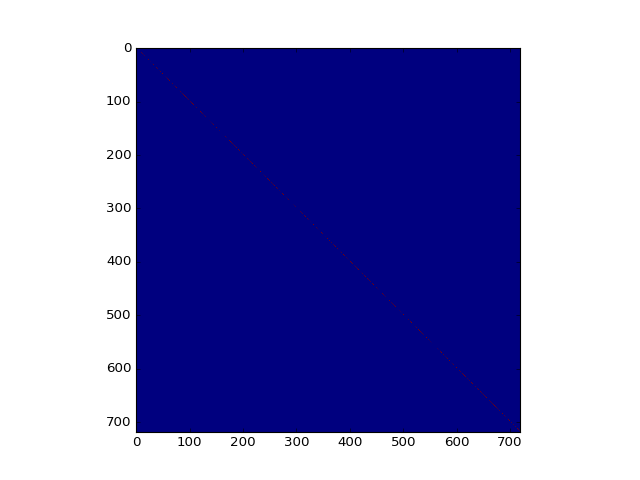

In [18]:
"""Check if Sw is invertible"""
TrSw_reg = TrSw+np.identity(719)*1e-10 # add regularisation to ensure invertible
print np.linalg.det(TrSw_reg) # determininant undef due to linalg library algorithm?
print np.trace(TrSw_reg), np.trace(TrSw) # check regularisation introduces only a minor error
"""Calculate inverse anyway and verify that Inv * Matrix = Identity"""
maybeidentity = np.dot(np.linalg.pinv(TrSw_reg),TrSw_reg)
plt.figure()
plt.imshow(maybeidentity>=1)
plt.show()

# Get eigenvalues and eigenvectors

In [45]:
# Get eigenvectors and eigenvalues
def lda(Sb,Sw):
    """
    LDA: 
    1.Returns eigenvectors and eigenvalues in sorted order of eigenvalues.
    """
#     print Sb.shape, Sw.shape
#     U, EVals, EVecs = np.linalg.svd(np.dot(np.linalg.pinv(Sw),Sb))
    EVals, EVecs = np.linalg.eig(np.dot(np.linalg.pinv(Sw),Sb))
    EVecs = EVecs.T
    EValsSorted = np.flipud(np.sort(EVals)) # sorts eigenvalues in descending order
    EVecsSorted = (EVecs[np.flipud(np.argsort((EVals)))]) # sorts eigenvectors in the same order as EValsSorted
    return EValsSorted, EVecsSorted

In [46]:
# force_recompute = True
# if os.path.exists('lda_training_eigenvalues.npy') and os.path.exists('lda_training_eigenvectors.npy') and force_recompute==False:
#     TrD = np.load('lda_training_eigenvalues.npy')
#     TrU = np.load('lda_training_eigenvectors.npy') 
# else:
TrD, TrU = lda(TrSb,TrSw_reg)
#     np.save('lda_training_eigenvalues',TrD)
#     np.save('lda_training_eigenvectors',TrU)

In [47]:
print TrD

[  3.86768965e+00 +0.00000000e+00j   3.26272966e+00 +0.00000000e+00j
   2.88582055e+00 +0.00000000e+00j   1.72223722e+00 +0.00000000e+00j
   1.52081487e+00 +0.00000000e+00j   1.11652042e+00 +0.00000000e+00j
   8.04122323e-01 +0.00000000e+00j   5.54390452e-01 +0.00000000e+00j
   4.33013037e-01 +0.00000000e+00j   1.16414634e-14 +7.56210671e-16j
   1.16414634e-14 -7.56210671e-16j   1.10264026e-14 +0.00000000e+00j
   8.82437812e-15 +0.00000000e+00j   8.67360211e-15 +0.00000000e+00j
   8.21063755e-15 +0.00000000e+00j   7.95614662e-15 +8.75953856e-16j
   7.95614662e-15 -8.75953856e-16j   7.52623068e-15 +8.58815224e-16j
   7.52623068e-15 -8.58815224e-16j   7.24710197e-15 +2.96401045e-16j
   7.24710197e-15 -2.96401045e-16j   7.05526216e-15 +0.00000000e+00j
   6.32293484e-15 +3.82286483e-16j   6.32293484e-15 -3.82286483e-16j
   6.10792204e-15 +7.39993127e-16j   6.10792204e-15 -7.39993127e-16j
   5.96891210e-15 +1.53814765e-15j   5.96891210e-15 -1.53814765e-15j
   5.79532209e-15 +4.62439691e-16j

<IPython.core.display.Javascript object>


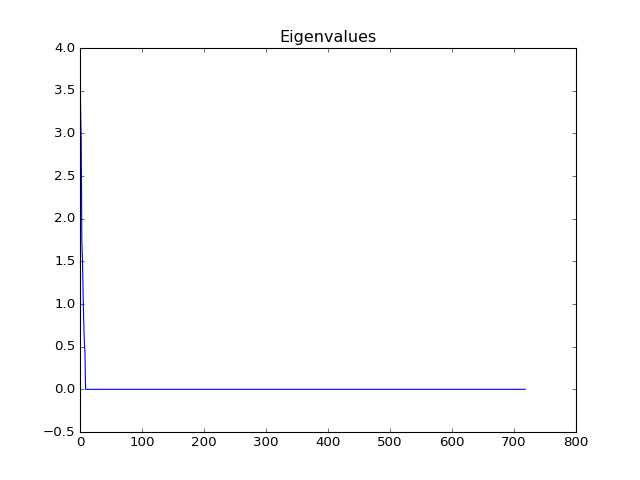

/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


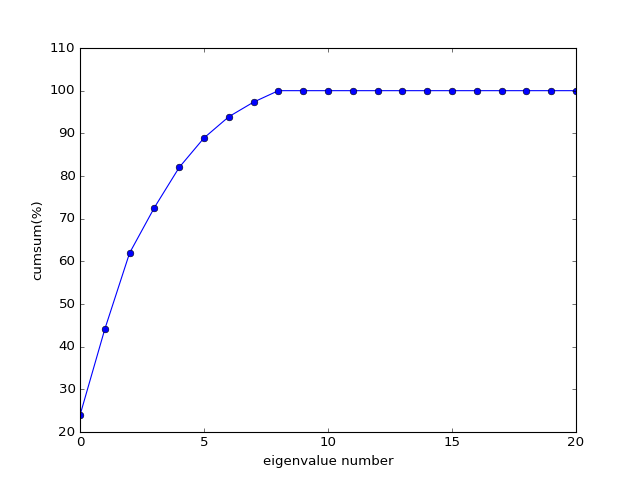

<IPython.core.display.Javascript object>


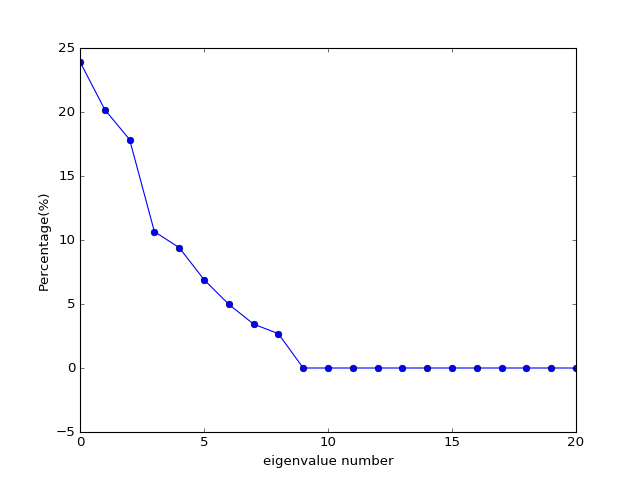

In [39]:
plt.figure()
plt.title('Eigenvalues')
plt.plot(TrD)
plt.figure()
plt.xlabel('eigenvalue number')
plt.ylabel('cumsum(%)')
plt.xlim(0,20)
plt.plot(np.cumsum(TrD)*100/np.sum(TrD),marker='o')
plt.figure()
plt.plot(TrD*100/np.sum(TrD),marker='o')
plt.xlim(0,20)
plt.xlabel('eigenvalue number')
plt.ylabel('Percentage(%)')
# plt.semilogy()

# Reduced Components

In [22]:
def Comps(Imgs, u, p):
    """
    Components in Reduced Dimensions:
    1. picks up p columns of u as a reduced basis set.
    2. returns the component sizes
    
    :params p: reduced dimension to output
    """
#     uCols = u[:p] #  transpose to get columns, use the first p columns
#     return np.dot(uCols,Imgs.T)
    return np.array([
        [np.inner(u[i]/np.sqrt(np.inner(u[i],u[i])),(img)) for i in np.arange(p)] 
                     for img in Imgs
    ])

In [48]:
Imgs2Comps = Comps(TrImgs,TrU,2)
Imgs3Comps = Comps(TrImgs,TrU,3)
Imgs9Comps = Comps(TrImgs,TrU,9)

In [49]:
cmeans = ClassMeans(TrImgs,TrLbls)
meanys = Comps(cmeans,TrU,2).T
meanys3 = Comps(cmeans,TrU,3).T

Doing class 9



## 2-component visualisation

<IPython.core.display.Javascript object>


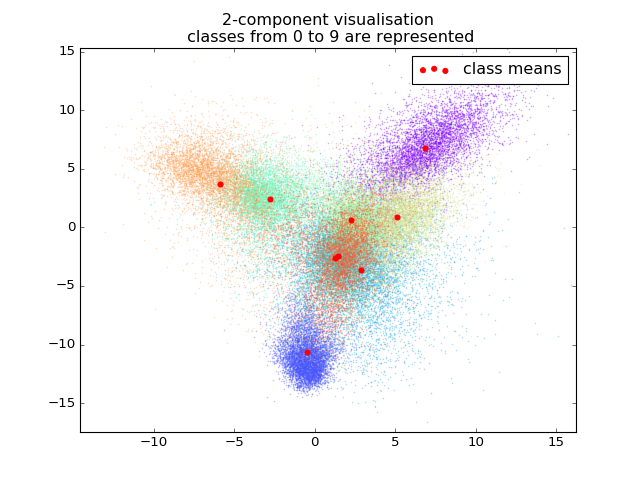

In [62]:
clriterator = plt.cm.rainbow(np.linspace(0,1,10))
(j,k) = (0,9) #class range to sketch for
plt.figure(figsize=(8,6))
plt.title('2-component visualisation\n classes from {} to {} are represented'.format(j,k))
[plt.scatter(Imgs2Comps[:,0][TrLbls==Class][:],Imgs2Comps[:,1][TrLbls==Class][:],
             alpha=1,
             marker='.',
             s = 0.1,
             color=clriterator[Class],
#              label=c
            ) 
 for Class in np.unique(TrLbls)[j:k]]
plt.xlim(*mm(Imgs2Comps[:,0]))
plt.ylim(*mm(Imgs2Comps[:,1]))
plt.scatter(meanys[0][j:k],meanys[1][j:k],alpha=1,color='red',label='class means')
plt.legend()

# 3-component visualisation

<IPython.core.display.Javascript object>


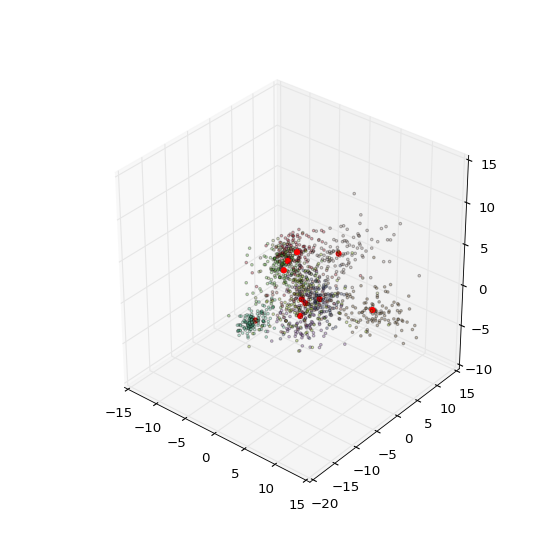

In [51]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
j = 10
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
[ax.scatter(Imgs3Comps[:,0][TrLbls==c][::50],
            Imgs3Comps[:,1][TrLbls==c][::50],
            Imgs3Comps[:,2][TrLbls==c][::50],
            marker='.',alpha=0.3,c=np.random.rand(4,4))
 for c in np.unique(TrLbls)[:j]
]
ax.scatter(meanys3[0][:j],meanys3[1][:j],meanys3[2][:j],alpha=1,color='red')
# ax.set_xlim(np.min(Imgs3Comps[0]),np.max(Imgs3Comps[0]))
# ax.set_ylim(np.min(Imgs3Comps[1]),np.max(Imgs3Comps[1]))
# ax.set_zlim(np.min(Imgs3Comps[2]),np.max(Imgs3Comps[2]))
plt.show()

# Image Classification

In [52]:
def KCl(x,TrImgsPComps):
    """
    K-Nearest neighbours classifier
    1. Compute relative distances between x(one picture) and TrImgsPComps(many pictures)
    2. Find nearest neighbor's class: use this to classify x.
    
    Note: Ensure x and elements in TrImgsPComps have the same number of components.
    """
    try:
        EucDist = dist.cdist(x,TrImgsPComps)
#         print EucDist
        NeighborIdx = np.argmin(EucDist)
        NeighborLbl = TrLbls[NeighborIdx]
        return (NeighborLbl)
    except:
        raise

In [53]:
Ts2Comps = Comps(TsImgs,TrU,2)
Ts3Comps = Comps(TsImgs,TrU,3)
Ts9Comps = Comps(TsImgs,TrU,9)

In [54]:
def classification_accuracy(TsImgsPComps,TsLbls,TrImgsPComps):
    N = len(TsLbls)
    result = np.array([KCl(TsImgsPComps[i:i+1],TrImgsPComps) for i in np.arange(N)])
    accuracy = np.sum(np.equal(result,TsLbls))/N
    return accuracy

In [55]:
print 'Classification Accuracy'
print '2-Components', classification_accuracy(Ts2Comps,TsLbls,Imgs2Comps) * 100, '%'
print '3-Components', classification_accuracy(Ts3Comps,TsLbls,Imgs3Comps) * 100, '%'
print '9-Components', classification_accuracy(Ts9Comps,TsLbls,Imgs9Comps) * 100, '%'

Classification Accuracy
2-Components

/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:620: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order='C', ndmin=1)


 47.41 %
3-Components 66.64 %
9-Components 89.5 %


# Max dimensionality to be projected

In [201]:
np.linalg.matrix_rank(TrU)

719